<a href="https://colab.research.google.com/github/ujeongmin/ESAA/blob/main/ESAA_HW_5_31_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Keras CNN Dog or Cat Classification**

## Import Library

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from google.colab import drive
drive.mount('/content/gdrive')
import os
print(os.listdir("/content/gdrive/MyDrive/ESAA/data/CNNdogorcat"))

Mounted at /content/gdrive
['sampleSubmission.csv', 'test1.zip', 'train.zip']


## Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [7]:
# 압축 파일의 위치
test_set_path = "/content/gdrive/MyDrive/ESAA/data/CNNdogorcat/test1.zip"
train_set_path = "/content/gdrive/MyDrive/ESAA/data/CNNdogorcat/train.zip"

# 저장할 경로
extract_folder = 'dataset/'  # 코랩 환경에 임시 저장

# 압축 해제
import shutil
shutil.unpack_archive(test_set_path, extract_folder)
shutil.unpack_archive(train_set_path, extract_folder)

In [18]:
filenames = os.listdir('dataset/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [20]:
df.head()

filename  category
0  dog.10867.jpg         1
1   dog.6113.jpg         1
2   cat.8399.jpg         0
3   cat.5107.jpg         0
4   cat.3441.jpg         0

In [21]:
df.tail()

filename  category
24995  cat.11535.jpg         0
24996  cat.10729.jpg         0
24997   cat.6814.jpg         0
24998   cat.1828.jpg         0
24999  dog.10189.jpg         1

### See Total In count

<Axes: xlabel='category'>

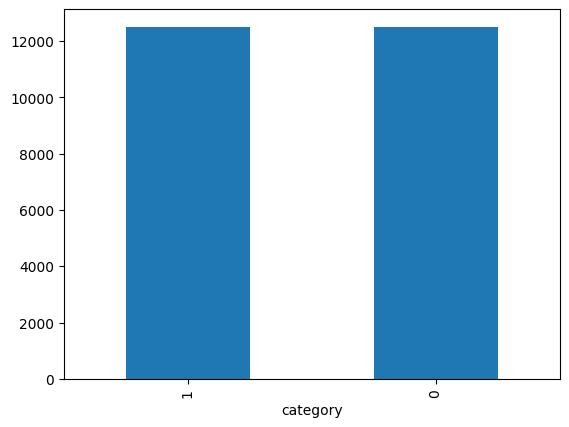

In [22]:
df['category'].value_counts().plot.bar()

## See sample image

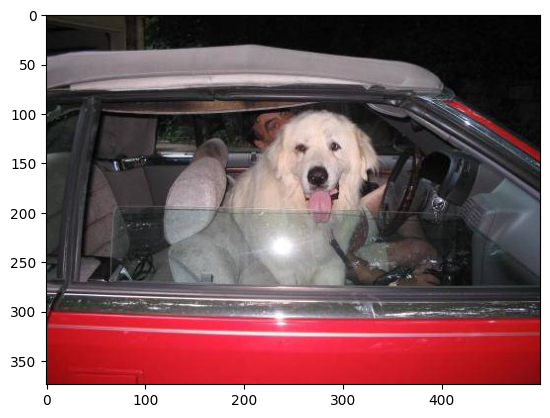

In [25]:
sample = random.choice(filenames)
image = load_img("dataset/train/"+sample)
plt.imshow(image)

## Build Model
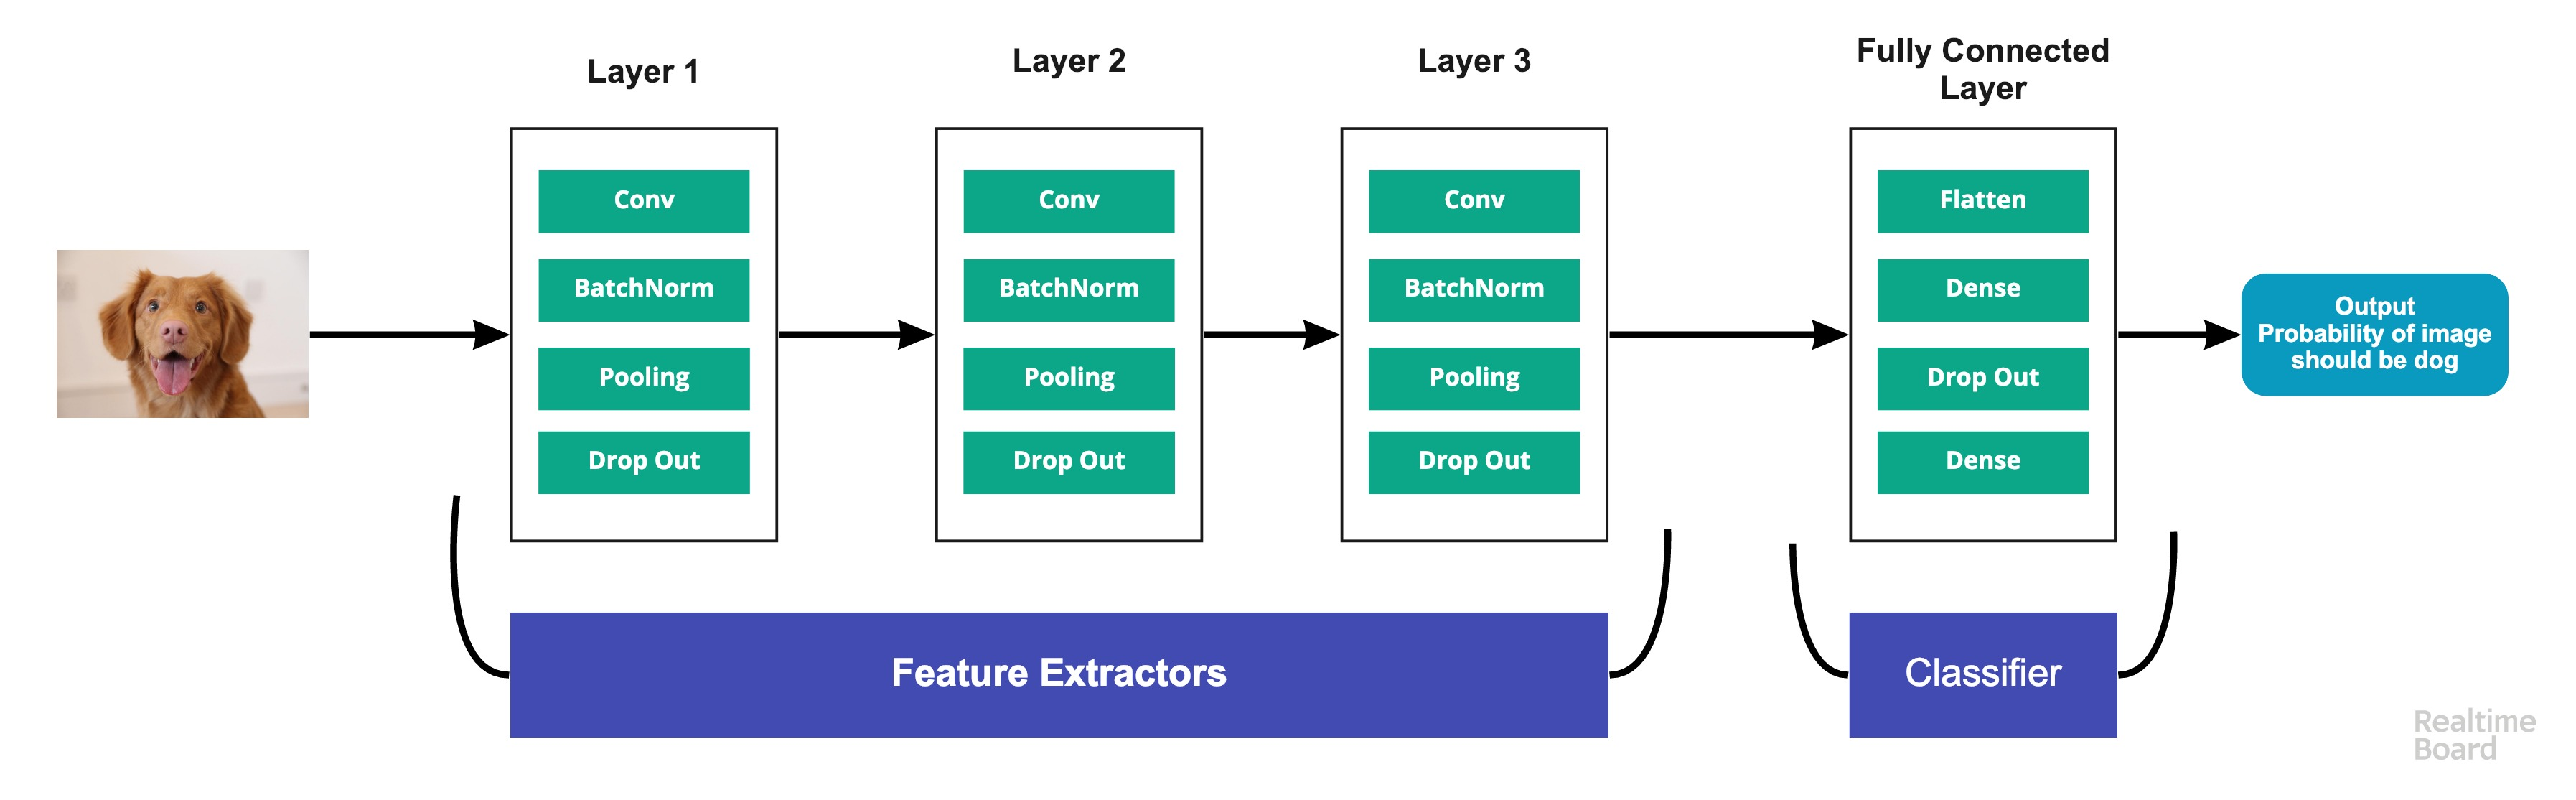  
* Input Layer: 입력 이미지 데이터. 이미지를 단일 치수 배열로 재구성 ex) 이미지가 64x64 = 4096이면 (4096,1) 배열로 변환  
* Conv Layer: 이미지에서 특징을 추출  
* Pooling Layer: convolution 후 입력 이미지의 볼륨 줄임  
* Fully Connected Layer: 계층에서 다른 계층으로 네트워크를 연결
* Output Layer: 예측값 레이어

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

## Callbacks
Early Stop : 과적합 방지를 위해 10 epoch 후 학습 중지

In [27]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

Learning Rate Reduction : 2 epoch 동안 정확도가 증가하지 않으면 학습률 감소시킴

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [42]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data
image generator를 사용하기 위해 범주형 칼럼을 문자열로 변환(Dog 1, Cat 0)

In [29]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [30]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

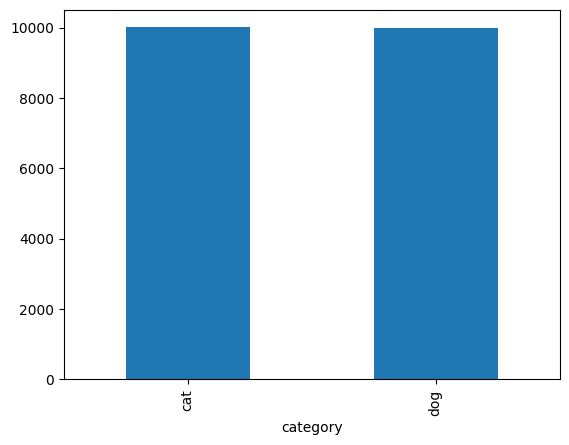

In [31]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

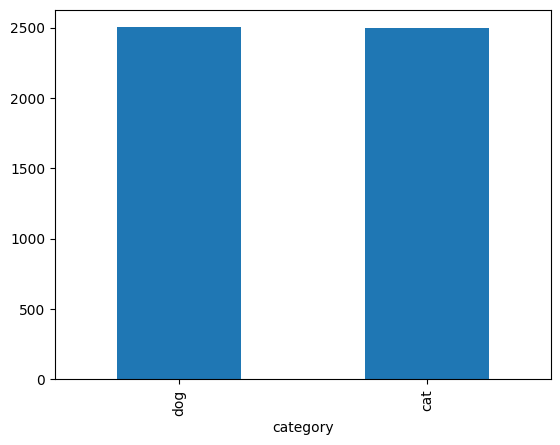

In [32]:
validate_df['category'].value_counts().plot.bar()

In [33]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training Generator

In [37]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "dataset/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


Validation Generator

In [38]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "dataset/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## See how our generator work

In [39]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "dataset/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


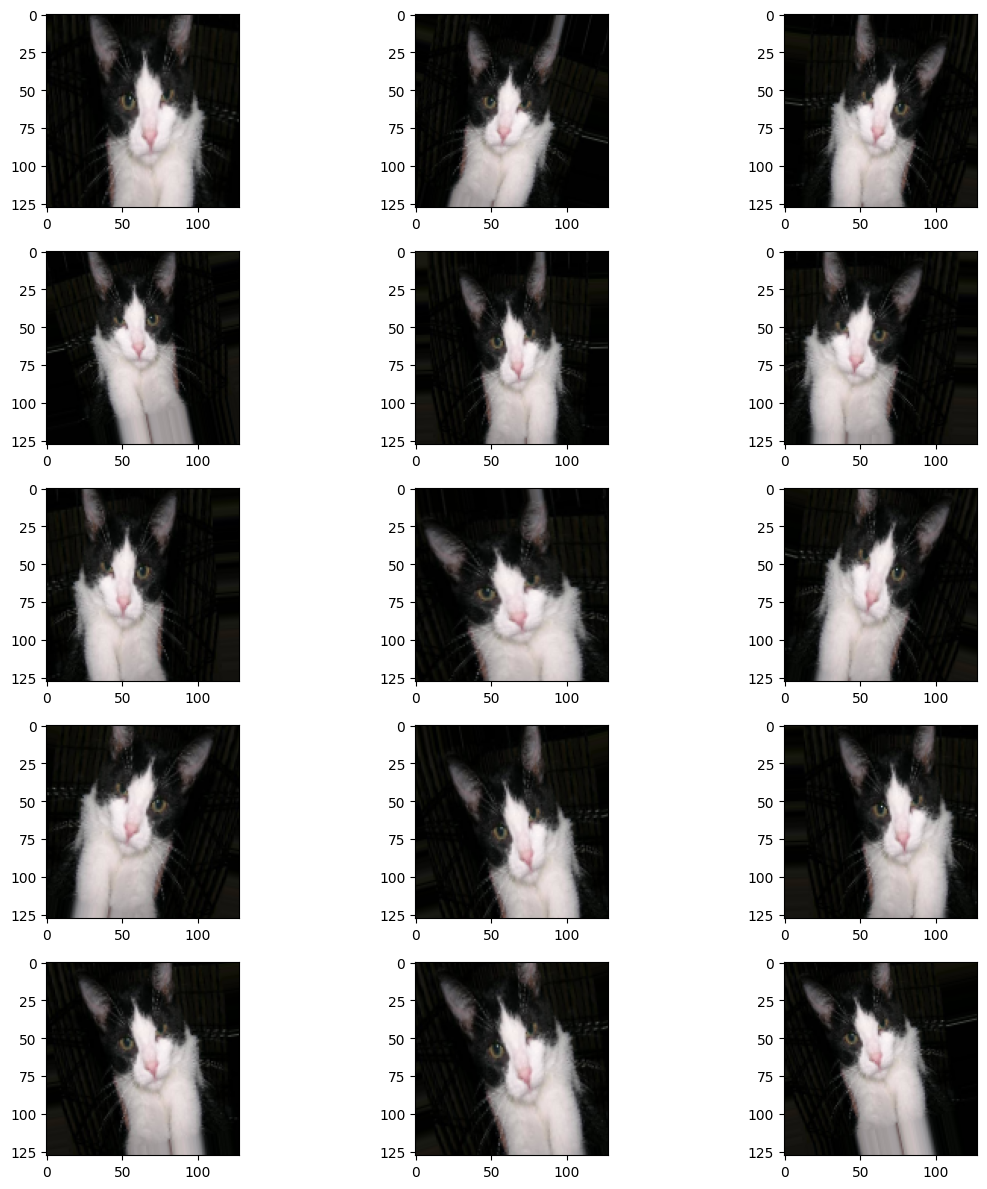

In [40]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [44]:
epochs=3 if FAST_RUN else 3
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3


<ipython-input-44-4fd6da93749c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.6928

1333/1333 [==============================] - 1324s 993ms/step - loss: 0.5960 - accuracy: 0.6928 - val_loss: 1.1380 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - ETA: 0s - loss: 0.5240 - accuracy: 0.7472

1333/1333 [==============================] - 1223s 918ms/step - loss: 0.5240 - accuracy: 0.7472 - val_loss: 0.6353 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.7748

1333/1333 [==============================] - 1235s 927ms/step - loss: 0.4844 - accuracy: 0.7748 - val_loss: 0.4150 - val_accuracy: 0.8120 - lr: 0.0010


## Save Model

In [45]:
model.save_weights("model.h5")

## Virtualize Training

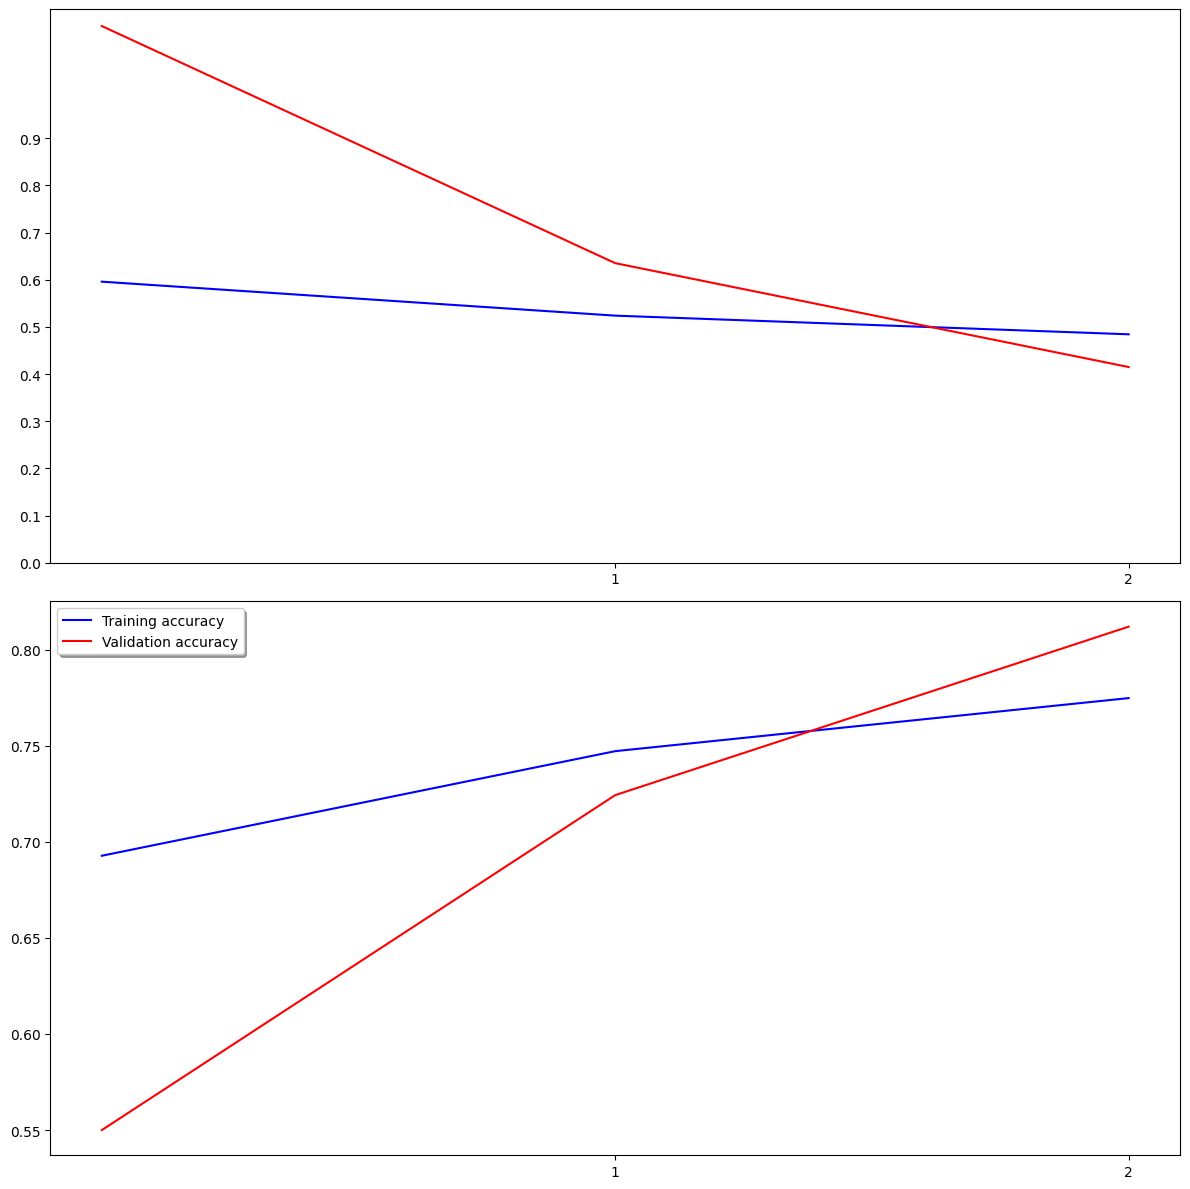

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [52]:
test_filenames = os.listdir("dataset/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [53]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "dataset/test1",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict


In [54]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-54-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


범주형 분류의 경우 각 범주에 해당할 확률이 예측되므로 numpy average max를 사용해 확률이 가장 높은 범주를 선택

In [55]:
test_df['category'] = np.argmax(predict, axis=-1)

train_generator.class_index를 사용하여 예측 범주를 다시 generator 클래스로 변환

In [56]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

데이터를 {1: 'dog', 0: 'cat'}로 매핑

In [57]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

Virtaulize Result

<Axes: xlabel='category'>

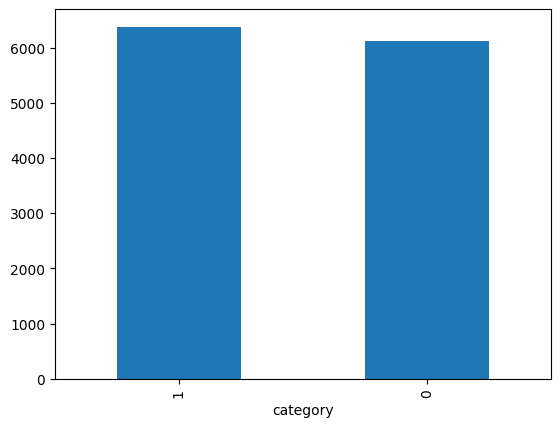

In [58]:
test_df['category'].value_counts().plot.bar()

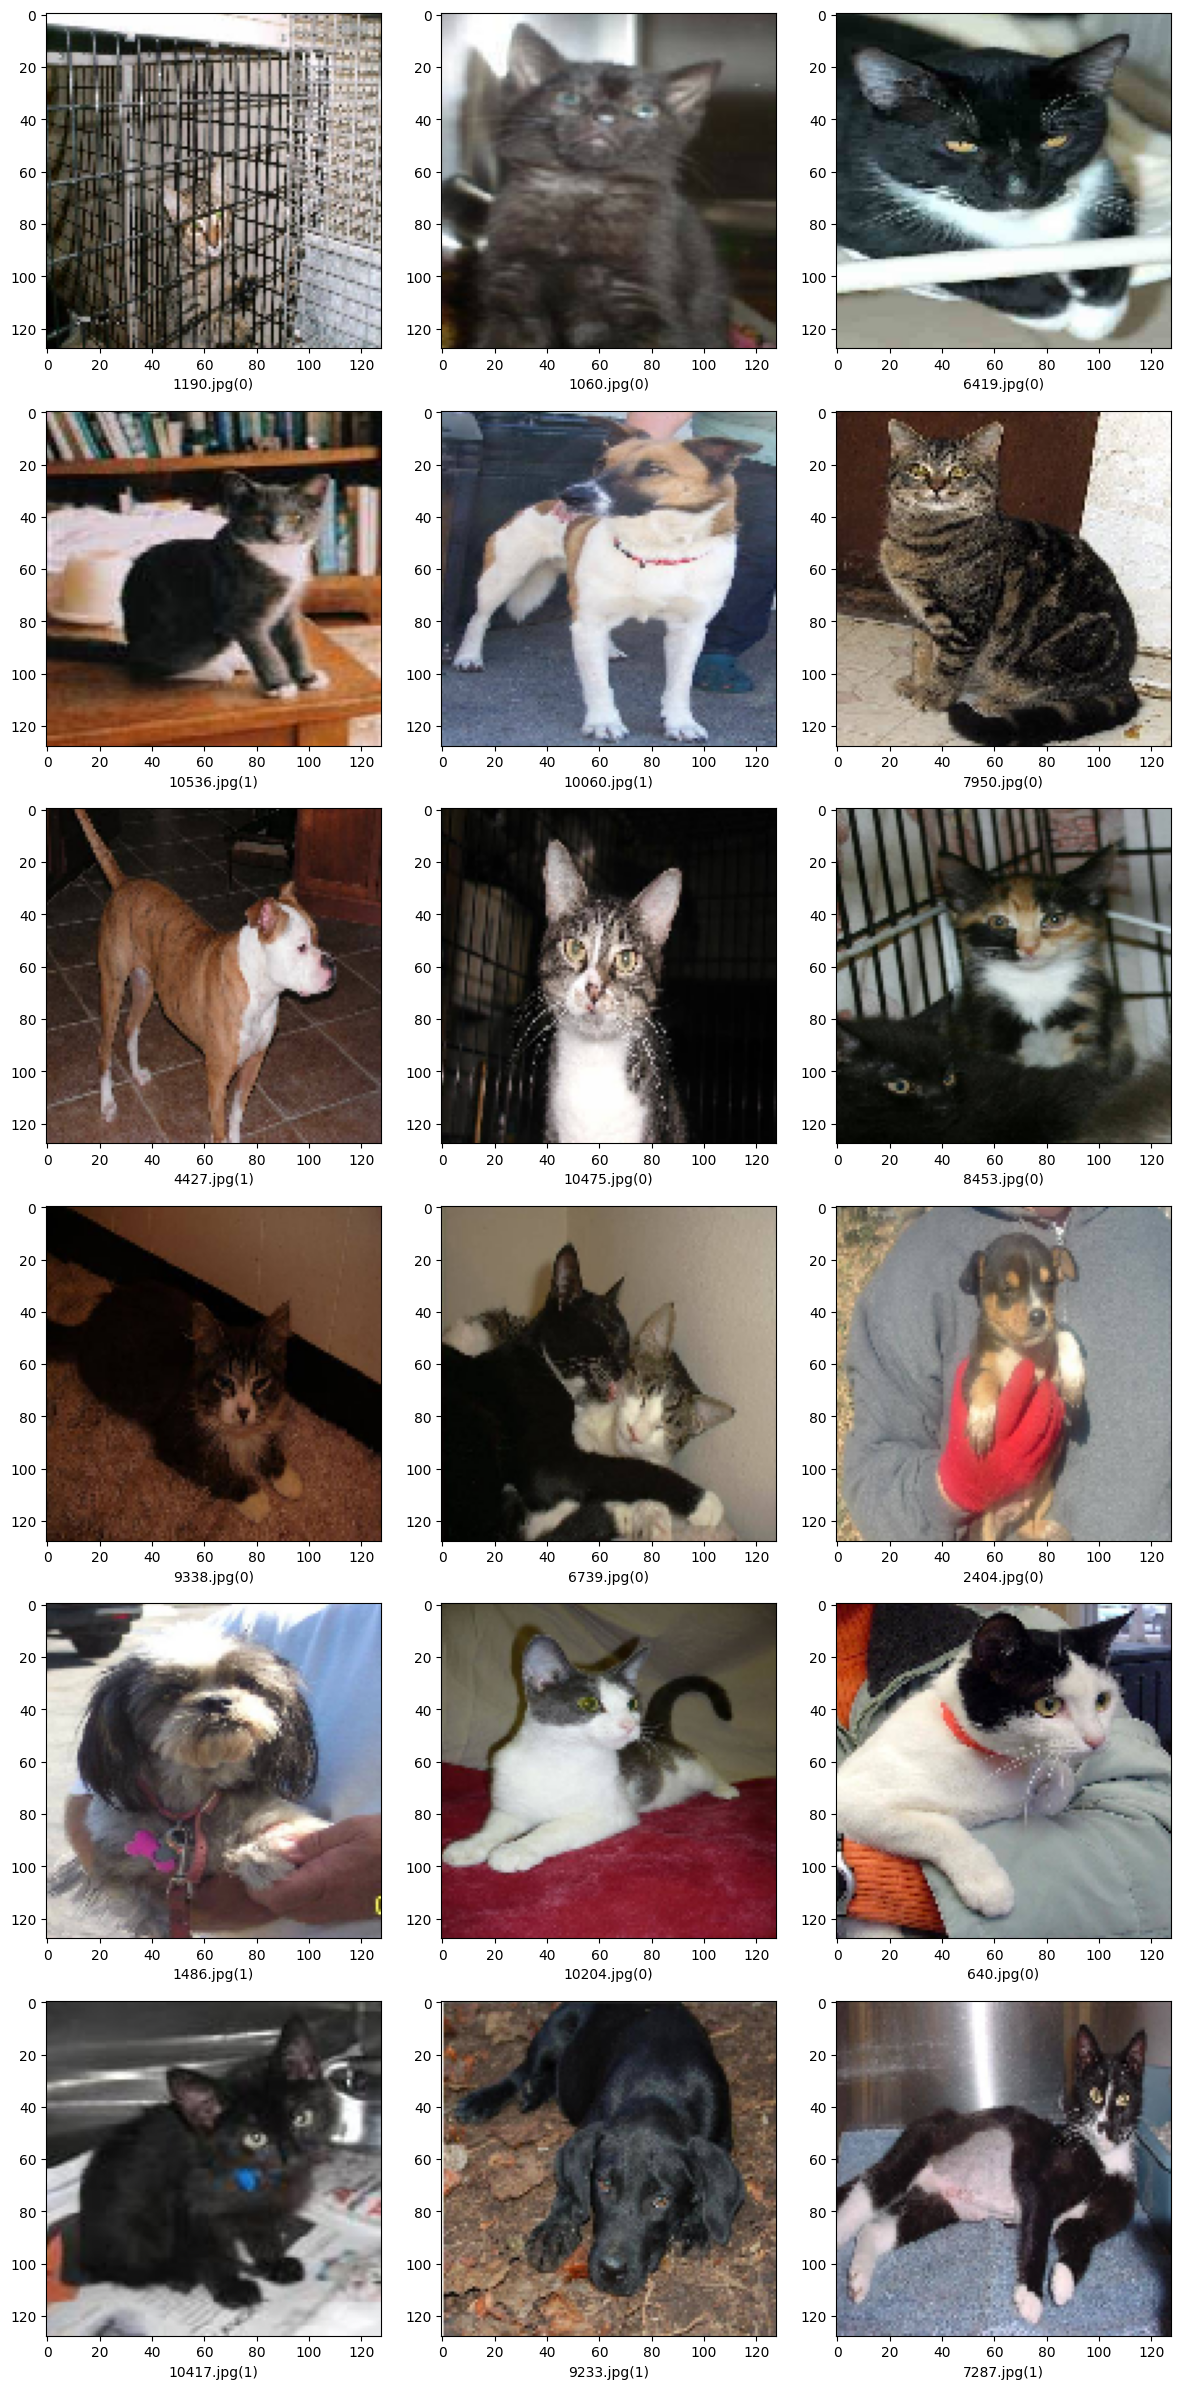

In [59]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("dataset/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)